In [2]:
!pip install -q langchain langchain_core langchain-google-genai langchain_community langgraph

### Import Liberary

In [20]:

import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod


from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings

from IPython.display import display, Image, Markdown

In [13]:
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [14]:
def load_gemini_embedding():
        try:
            embedding = GoogleGenerativeAIEmbeddings(
                            model="models/text-embedding-004",
                            task_type="retrieval_document"
                        )
            print('Gemini Embedding successfully loaded')
            return embedding
        except Exception as e:
            print(f'Error Gemini Embedding: {str(e)}')
            raise

def load_gemini_model():
    try:
        model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                            temperature=0.1,
                            # convert_system_message_to_human=True,
                            max_tokens=512,
                            timeout=None,
                            max_retries=2,
                            top_k=90,
                            top_p=0.5
                        )
        print('Gemini Model successfully loaded')
        return model
    except Exception as e:
        print(f'Error loading Gemini Model: {str(e)}')
        raise


In [15]:
embedding = load_gemini_embedding()
model = load_gemini_model()

Gemini Embedding successfully loaded
Gemini Model successfully loaded


In [22]:
ai_response = model.invoke('wgat is agents')
Markdown(ai_response.content)

The term "agents" has many meanings depending on the context.  Here are a few possibilities:

* **In artificial intelligence (AI):** An agent is a computer program or system that perceives its environment and takes actions to maximize its chances of successfully achieving its goals.  This is a broad definition encompassing everything from simple rule-based systems to complex machine learning models.  Examples include game-playing AI, robotic control systems, and chatbots.

* **In software engineering:** An agent can refer to a software component that acts on behalf of a user or another program.  This might involve tasks like monitoring system performance, managing resources, or interacting with other systems.

* **In business and economics:** An agent is a person who acts on behalf of another person or organization.  This could be a real estate agent, a travel agent, or a representative of a company.

* **In law:** An agent is a person authorized to act on behalf of another person or entity, with the power to bind the principal to contracts or other obligations.

* **In biology:** An agent can refer to a biological entity that causes a particular effect, such as an infectious agent (a virus or bacterium).


To understand what "agents" means, you need to consider the context in which the word is used.  Could you provide more information about where you encountered this term?  Knowing the context will help me give you a more precise and helpful answer.

## Creating Graph and respective tools

In [39]:
class StatePlanner(TypedDict):
    messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

In [40]:
# Test data
test_data: StatePlanner = {
    "messages": [
        HumanMessage(content="I'm planning a trip to Paris. Any recommendations?"),
        AIMessage(content="Sure! What are your interests?"),
        HumanMessage(content="I love museums and food tours."),
        AIMessage(content="Great! I can suggest some museums and local food experiences."),
    ],
    "city": "Paris",
    "interests": ["museums", "food tours"],
    "itinerary": "Day 1: Visit the Louvre, followed by a Seine river cruise. Day 2: Explore Montmartre and enjoy a local food tour."
}


StatePlanner(test_data)

{'messages': [HumanMessage(content="I'm planning a trip to Paris. Any recommendations?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Sure! What are your interests?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='I love museums and food tours.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Great! I can suggest some museums and local food experiences.', additional_kwargs={}, response_metadata={})],
 'city': 'Paris',
 'interests': ['museums', 'food tours'],
 'itinerary': 'Day 1: Visit the Louvre, followed by a Seine river cruise. Day 2: Explore Montmartre and enjoy a local food tour.'}

In [41]:
# Itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a knowledgeable and friendly travel assistant. Create a personalized and engaging day trip itinerary for {city} based on the user's interests: {interests}. Include key attractions, dining recommendations, and unique experiences. Make it concise yet informative."),
    ("human", "Can you provide a well-structured itinerary for my day trip, considering my preferences?")
])



# itinerary_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
#     ("human", "Create an itinerary for my day trip."),
# ])

Define Tools for Agent

In [42]:
def input_city(state: StatePlanner) -> StatePlanner:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("User Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_interest(state: StatePlanner) -> StatePlanner:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
  user_message = input("User Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }


def create_itinerary(state: StatePlanner) -> StatePlanner:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = model.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary" : response.content,
  }

Create Graph

In [43]:

workflow = StateGraph(StatePlanner)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

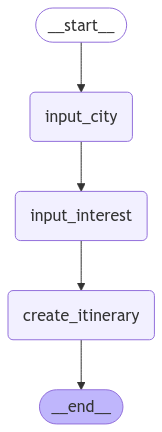

In [44]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

### Run the app

In [62]:

def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [63]:

user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
User Input: mumbai
Please enter your interest for the trip to : mumbai (comma-separted): 
User Input: meeting with client
Creating an itinerary for mumbai based on interests : meeting with client

Final Itinerary: 
Please tell me more about your day trip! To create the best itinerary for you, I need some information:

* **What is the purpose of your trip?** (e.g., sightseeing, business meeting, relaxation)
* **What are your interests?** (e.g., history, food, art, nightlife)
* **What is your budget?** (e.g., luxury, mid-range, budget-friendly)
* **How much time do you have?** (e.g., a full day, half a day)
* **Where will you be staying?** (This helps me suggest convenient transportation options.)
* **Do you have any accessibility needs?**

Once I have this information, I can create a personalized itinerary for your Mumbai day trip.


In [64]:
ans = app.invoke({
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  })

Please enter the city you want to visit for your day trip: 
User Input: mumbai
Please enter your interest for the trip to : mumbai (comma-separted): 
User Input: clent meeting
Creating an itinerary for mumbai based on interests : clent meeting

Final Itinerary: 
Please tell me more about your day trip! To create the best itinerary for you, I need some information:

* **What is the purpose of your trip?** (e.g., sightseeing, business, relaxation)
* **What are your interests?** (e.g., history, food, art, nightlife, shopping)
* **What is your budget?** (e.g., luxury, mid-range, budget)
* **How much time do you have?** (e.g., a full day, half a day)
* **Where will you be staying?** (This helps me suggest convenient transportation options.)


Once I have this information, I can create a personalized itinerary for your Mumbai day trip.


In [52]:
ans['messages']

[HumanMessage(content='I want to plan a day trip', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='mumbai', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='beach', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Please tell me your interests!  To create the best itinerary for your Mumbai day trip, I need to know what you'd like to see and do.  For example, are you interested in history, food, beaches, nightlife, shopping, or something else?", additional_kwargs={}, response_metadata={})]

In [54]:
ans['city'], ans['interests']

('mumbai', ['beach'])

In [55]:
ans['itinerary']

"Please tell me your interests!  To create the best itinerary for your Mumbai day trip, I need to know what you'd like to see and do.  For example, are you interested in history, food, beaches, nightlife, shopping, or something else?"

## Gradio App without StateGraph

In [57]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00


In [61]:

import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

class StatePlanner(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                temperature=0.1,
                # convert_system_message_to_human=True,
                max_tokens=512,
                timeout=None,
                max_retries=2,
                top_k=90,
                top_p=0.5
              )

# Define the itinerary prompt
# Itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a knowledgeable and friendly travel assistant. Create a personalized and engaging day trip itinerary for {city} based on the user's interests: {interests}. Include key attractions, dining recommendations, and unique experiences. Make it concise yet informative."),
    ("human", "Can you provide a well-structured itinerary for my day trip, considering my preferences?")
])

def input_city(city: str, state: StatePlanner) -> StatePlanner:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: StatePlanner) -> StatePlanner:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: StatePlanner) -> str:
    response = model.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22b5526a21335e6e6c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [60]:
interface.close()

Closing server running on port: 7860


## Gradio App with StateGraph

In [78]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# Define the state for the graph
class StatePlanner(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                temperature=0.1,
                max_tokens=512,
                timeout=None,
                max_retries=2,
                top_k=90,
                top_p=0.5
              )

# Itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a knowledgeable and friendly travel assistant. Create a personalized and engaging day trip itinerary for {city} based on the user's interests: {interests}. Include key attractions, dining recommendations, and unique experiences. Make it concise yet informative."),
    ("human", "Can you provide a well-structured itinerary for my day trip, considering my preferences?")
])

# Function to process city input (Fix: Only takes `state`)
def input_city(state: StatePlanner) -> StatePlanner:
    city = state["city"]  # Extract city from state
    return {
        **state,
        "messages": state["messages"] + [HumanMessage(content=city)],
    }

# Function to process interest input (Fix: Only takes `state`)
def input_interests(state: StatePlanner) -> StatePlanner:
    interests = state["interests"]  # Extract interests from state
    return {
        **state,
        "messages": state["messages"] + [HumanMessage(content=", ".join(interests))],
    }

# Function to generate itinerary (Fix: Only takes `state`)
def create_itinerary(state: StatePlanner) -> StatePlanner:
    response = model.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return state

# Function to create the StateGraph workflow
def create_stategraph_workflow():
    # creating StateGraph
    workflow = StateGraph(StatePlanner)

    # creating nodes of graph
    workflow.add_node("input_city", input_city)
    workflow.add_node("input_interest", input_interests)
    workflow.add_node("create_itinerary", create_itinerary)

    # creating connection between nodes
    workflow.set_entry_point("input_city")
    workflow.add_edge("input_city", "input_interest")
    workflow.add_edge("input_interest", "create_itinerary")
    workflow.add_edge("create_itinerary", END)

    # compile the workflow
    return workflow.compile()

# Define the Gradio application function
def travel_planner(city: str, interests: str):
    state = {
        "messages": [],
        "city": city,   # Store city in state
        "interests": [interest.strip() for interest in interests.split(',')],  # Store interests in state
        "itinerary": "",
    }

    # invoke the graph
    app = create_stategraph_workflow()
    output_state = app.invoke(state)

    return output_state["itinerary"]  # Return the generated itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Markdown(label="Generated Itinerary"),  # ✅ Changed to Markdown
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ae4671af22c9cea425.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [76]:
# Test without Gradio

ans = travel_planner('mumbai', 'meeting with client')

In [77]:
Markdown(ans)

Okay, let's craft the perfect Mumbai day trip for you, focusing on efficiently meeting your client while still experiencing some of the city's charm.  To do this effectively, I need a little more information.  Please tell me:

1. **Where is your client located?** (Specific address or area would be helpful)  This will help me optimize travel time.
2. **What time does your meeting start and end?** This dictates the structure of the day.
3. **What's your client's preferred style of meeting?** (Formal business meeting, informal lunch, etc.) This helps me suggest appropriate venues.
4. **Do you have any time before or after the meeting for sightseeing?** Even a short window can be used effectively.
5. **What's your preferred cuisine for lunch/dinner?** (Indian, International, etc.)


Once I have this information, I can create a truly personalized and efficient itinerary for your Mumbai day trip.